# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

!pip install git+https://github.com/AI-Guru/ngdlm.git
tf.compat.v1.disable_eager_execution()

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-woispeqv
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-woispeqv
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=dd617077217d511748a12ca5eca1e6bb225f83e79ba5ab3b7247dca93f20241d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yy45rh7/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/sound-of-failure


# Import Own Modules

In [3]:
sys.path += ['src/01_data_processing', 'src/02_modelling', 'src/03_modell_evaluation','src/00_utils']

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import naming
import eval_model_autoencoder as eval

# Global constants

### Get an overview of available configurations
Each configuration is identified by a run ID. This run ID is used for storing/loading 
*   configuration files
*   fitted scalers 
*   trained models 

The paths are retrieved by calling utility functions:

In [4]:
run_id = 'example_run_id'
print(f'Config path: {naming.get_conf_path(run_id)}')
print(f'Scaler path: {naming.get_scaler_path(run_id)}')
print(f'Model path: {naming.get_model_path(run_id)}')

Config path: conf/example_run_id.ini
Scaler path: models/example_run_id.gz
Model path: models/example_run_id.hdf5


To get an overview of existing run IDs and information on which types of files are stored under them, run
```
naming.show_run_ids()
```
Default run IDs are of the form 
```
run_id = "<model_name>_<noise>_<machine_type>_<machine_id>"
```
They are potentially overwritten when new configuration files are made using the script `make_conf_AE.py`. 
(See next section for details.)

In [5]:
naming.show_run_ids()

,run_id,conf,scaler,model,comment
0,AE_6dB_valve_id_00,True,False,False,Default run ID. Archive run to prevent overwri...
1,VAE_6dB_valve_id_00,True,True,False,Default run ID. Archive run to prevent overwri...
2,conf_VAE,True,False,False,
3,lstmAE_6dB_valve_id_00,True,True,True,Default run ID. Archive run to prevent overwri...
4,lstmAE_6dB_valve_id_00_1,True,True,True,
5,lstmAE_6dB_valve_id_02,True,False,False,Default run ID. Archive run to prevent overwri...


To archive a run, use
```
naming.archive_run(run_id)
```
The result can be seen as a new row in the run IDs overview table calling
```
naming.show_run_ids()
```
Finally, to delete a run simply call
```
naming.delete_run(run_id)
```

### Run scripts for building new config files.

Some of the parameters can be passed through the command line.
At present the command line parameters are the following :

1. make_conf_base.py : Script for building the base config file (saves in sound-of-failure/conf/conf_base.ini)
        -raw : Pass the location of the raw data dir


2. make_conf_AE.py : Script for building the config file holding the parameters for mel spectrogram and autoencoder. Autoencoders can be either conv. autoencoders, variational (conv.) autoencoders or LSTM autoencoders.
        -prj : directory that holds sound-of-failure
        -ae : AE, VAE or lstmAE
        -noise : Level of background noise (6dB, 0dB or min6dB)
        -type : Type of machine (valve, slider, pump or fan)
        -id : Machine ID (e.g. id_00)
        -mel : No. of mels
        -fft : No. of FFT bands
        -hop : Hop length for the sliding window while calculating FFT
        -dim : Time dimension of one spectrogram block after chunking the whole spectrogram
        -s : Step for the sliding window for creating chunks from one spectrogram


To check the description of the command line parameters one could activate the '-h' flag.

In [6]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_AE.py -h 

usage: make_conf_AE.py [-h] -prj _ [-ae] [-noise] [-type] [-id] [-mel] [-fft]
                       [-hop] [-dim] [-s]

Params for Spectrogram and Autoencoder (AE, VAE or lstmAE)

optional arguments:
  -h, --help            show this help message and exit
  -prj _, --project _   directory hat holds sound-of-failure
  -ae , --ae            Type of Autoencoder (AE, VAE or lstmAE)
  -noise , --noise      Level of background noise (6dB, 0dB or min6dB)
  -type , --type        Type of machine (valve, slider, pump or fan)
  -id , --id            Machine ID (e.g. id_00)
  -mel , --n_mels       No. of mel bands
  -fft , --n_fft        No. of FFT bands
  -hop , --hop_length   Hop length for FFT calc
  -dim , --dim          Time dimension of Spectrogram block
  -s , --step           Sliding window step for Spectrogram chunking


#### Note the change here: 
'noise', 'type' and 'id' must be specified to generate a config file.

In [7]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/mimii_baseline/dataset' -prj '/gdrive/MyDrive'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_AE.py -prj '/gdrive/MyDrive' -ae lstmAE -noise 6dB -type valve -id id_02 -mel 16 -fft 1024 -hop 512 -dim 32 -s 8

### Then read from the config files

There are two types of config files : 

1. Base configuration: sound-of-failure/conf/**conf_base**.ini
2. Autoencoder configuration: for example, sound-of-failure/conf/**AE_6dB_valve_id_00**.ini

##### Load base configuration.

In [9]:
base_conf = train.read_config('conf/conf_base.ini')

##### Select an autoencoder config file by specifying the run ID.

In [6]:
naming.show_run_ids()

,run_id,conf,scaler,model,comment
0,AE_6dB_valve_id_00,True,False,False,Default run ID. Archive run to prevent overwri...
1,VAE_6dB_valve_id_00,True,True,False,Default run ID. Archive run to prevent overwri...
2,conf_VAE,True,False,False,
3,lstmAE_6dB_valve_id_00,True,True,True,Default run ID. Archive run to prevent overwri...
4,lstmAE_6dB_valve_id_00_1,True,True,True,
5,lstmAE_6dB_valve_id_02,True,False,False,Default run ID. Archive run to prevent overwri...


In [7]:
run_id = naming.show_run_ids()['run_id'][3]
print(run_id)

conf_path = naming.get_conf_path(run_id)
param_conf = train.read_config(conf_path)

lstmAE_6dB_valve_id_00


#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [10]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
MODEL_NAME = param_conf.get('autoencoder', 'model_name')

if MODEL_NAME == 'lstmAE':
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'))
elif MODEL_NAME in ['AE', 'VAE']:
    LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
    NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
    NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'),
                   1)
else:
    print('Invalid model name.')


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [11]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW, overwrite=False)

 16%|█▌        | 157/991 [00:00<00:00, 1567.36it/s]

Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal
Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal
Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.


100%|██████████| 119/119 [00:00<00:00, 1757.28it/s]

Created 0 new spectrograms, kept 991 existing spectrograms.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.
Created 0 new spectrograms, kept 119 existing spectrograms.


#### 2. Separate train and test files

In [12]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                                DB, MACHINE_TYPE, MACHINE_ID, 
                                                                                random_seed=1)

# Manual data exploration

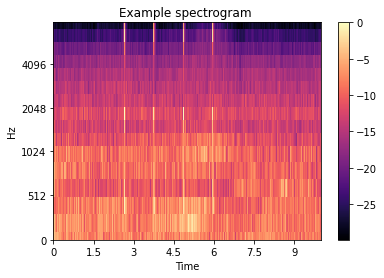

In [17]:
spect = np.load(spec.get_abnormal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0])

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

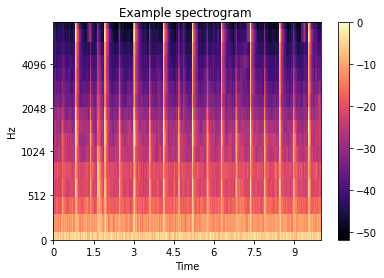

In [18]:
spect = np.load(spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0])

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

#### 3. Scaling

In [16]:
scaler_path = naming.get_scaler_path(run_id)
scaler = spec.fit_and_save_scaler(SCALER_TYPE, train_files, scaler_path, overwrite=False)

Loading existing scaler models/lstmAE_6dB_valve_id_00.gz.


In [21]:
naming.show_run_ids()

,run_id,conf,scaler,model,comment
0,AE_6dB_valve_id_00,True,False,False,Default run ID. Archive run to prevent overwri...
1,VAE_6dB_valve_id_00,True,True,False,Default run ID. Archive run to prevent overwri...
2,lstmAE_6dB_valve_id_00,True,True,False,Default run ID. Archive run to prevent overwri...
3,lstmAE_6dB_valve_id_00_1,True,True,True,
4,lstmAE_6dB_valve_id_02,True,False,False,Default run ID. Archive run to prevent overwri...


#### 4. Subsample data for training

In [22]:
if MODEL_NAME == 'lstmAE':
  train_data = splt.generate_train_data(train_files, scaler, DIM, STEP, as_images=False)
else:
  train_data = splt.generate_train_data(train_files, scaler, DIM, STEP, as_images=True)

100%|██████████| 872/872 [00:13<00:00, 64.43it/s]


In [23]:
model = train.load_new_model(MODEL_NAME, INPUT_SHAPE, NUM_NODES)
model.summary()

This is my LSTM autoencoder.
Model: "lstm_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 16)]          0         
_________________________________________________________________
encoder (Functional)         (None, 128)               337408    
_________________________________________________________________
decoder (Functional)         (None, 32, 16)            265232    
Total params: 602,640
Trainable params: 602,640
Non-trainable params: 0
_________________________________________________________________


In [24]:
train.compile_model(model=model, 
                    optimizer=OPTIMIZER, 
                    loss=LOSS,
                    learning_rate=0.001)

In [25]:
model_path = naming.get_model_path(run_id)
history = train.train_model(model=model,
                            train_data=train_data,
                            epochs=5,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            shuffle=SHUFFLE,
                            callback=True,
                            patience=15,
                            model_outdir=model_path)

Train on 29037 samples, validate on 3227 samples
Epoch 1/5
29037/29037 [==============================] - ETA: 0s - loss: 0.1845

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.08457, saving model to models/lstmAE_6dB_valve_id_00.hdf5
29037/29037 [==============================] - 169s 6ms/sample - loss: 0.1845 - val_loss: 0.0846
Epoch 2/5
29037/29037 [==============================] - ETA: 0s - loss: 0.0804
Epoch 00002: val_loss improved from 0.08457 to 0.05692, saving model to models/lstmAE_6dB_valve_id_00.hdf5
29037/29037 [==============================] - 166s 6ms/sample - loss: 0.0804 - val_loss: 0.0569
Epoch 3/5
29037/29037 [==============================] - ETA: 0s - loss: 0.0557
Epoch 00003: val_loss improved from 0.05692 to 0.04548, saving model to models/lstmAE_6dB_valve_id_00.hdf5
29037/29037 [==============================] - 166s 6ms/sample - loss: 0.0557 - val_loss: 0.0455
Epoch 4/5
29037/29037 [==============================] - ETA: 0s - loss: 0.0428
Epoch 00004: val_loss improved from 0.04548 to 0.03992, saving model to models/lstmAE_6dB_valve_id_00.hdf5
29037/29037 [==============================]

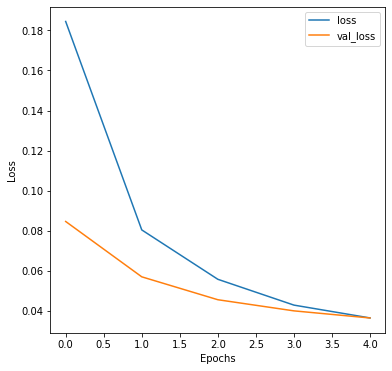

In [26]:
train.plot_train_history(history)

In [14]:
model_path = naming.get_model_path(run_id)
saved_model = train.load_saved_model(model_path)

In [19]:
# Reconstruction loss for test and train spectrograms
if MODEL_NAME == 'lstmAE':
  as_images = True
else:
  as_images = False


reco_loss_test = eval.reco_loss(model=saved_model, 
                                scaler=scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=test_files, 
                                as_images)

reco_loss_train = eval.reco_loss(model=saved_model, 
                                 scaler=scaler,
                                 dim=DIM,
                                 step=STEP,
                                 test_files=train_files, 
                                 as_images)

100%|██████████| 872/872 [01:04<00:00, 13.53it/s]


Roc AUC score=0.9620083327448625


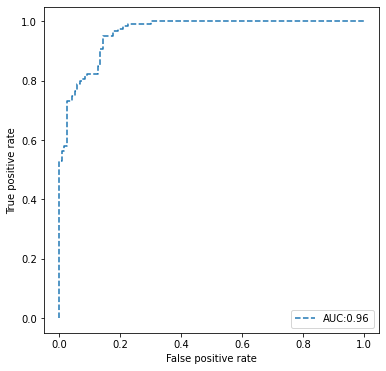

In [20]:
eval.plot_roc_curve(test_labels, reco_loss_test)

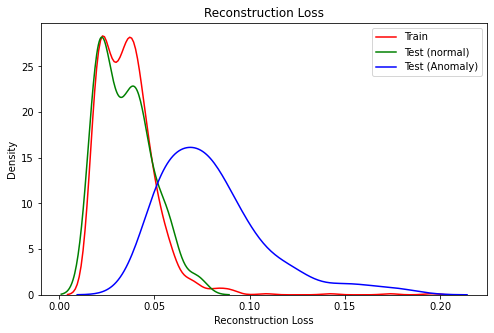

In [21]:
eval.plot_losses(y_true=test_labels,
                 y_pred=reco_loss_test,
                 y_train=reco_loss_train,
                 title="Reconstruction Loss",
                 xlabel='Reconstruction Loss')